# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas.plotting import lag_plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

import math
from math import sqrt

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Loading dataset

In [2]:
# flight_4 = pd.read_csv("Combined_Data_Apr21.csv")
# flight_5 = pd.read_csv("Combined_Data_May21.csv")
# flight_6 = pd.read_csv("Combined_Data_Jun21.csv")
# flight_4 = flight_4.append(flight_5)
# flight_4 = flight_4.append(flight_6)

In [3]:
flight_4 = pd.read_csv("Combined_Data_All.csv")
light = flight_4[["Timestamp", "Num_Flights", "Num_Covid_Cases"]]

In [4]:
data = light.groupby(by=["Timestamp"]).sum()
data.reset_index()
data

,Num_Flights,Num_Covid_Cases
Timestamp,,
2020-01-22,7545,655.0
2020-01-23,8979,98.0
2020-01-24,9124,286.0
2020-01-25,7654,492.0
2020-01-26,6751,684.0
...,...,...
2022-01-27,8174,3122335.0
2022-01-28,8376,3138982.0
2022-01-29,6924,2146044.0


# Visualizing train data

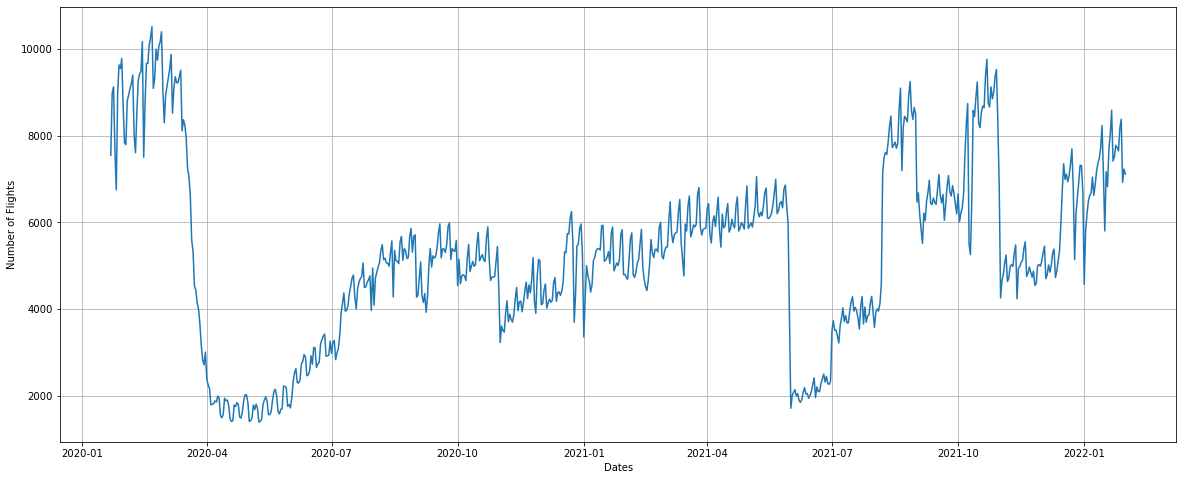

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data.csv', sep=',', parse_dates=['Timestamp'], index_col='Timestamp',date_parser=dateparse)
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Number of Flights')
plt.plot(data['Num_Flights']);
plt.show()

# Plotting autocorrelation

No handles with labels found to put in legend.


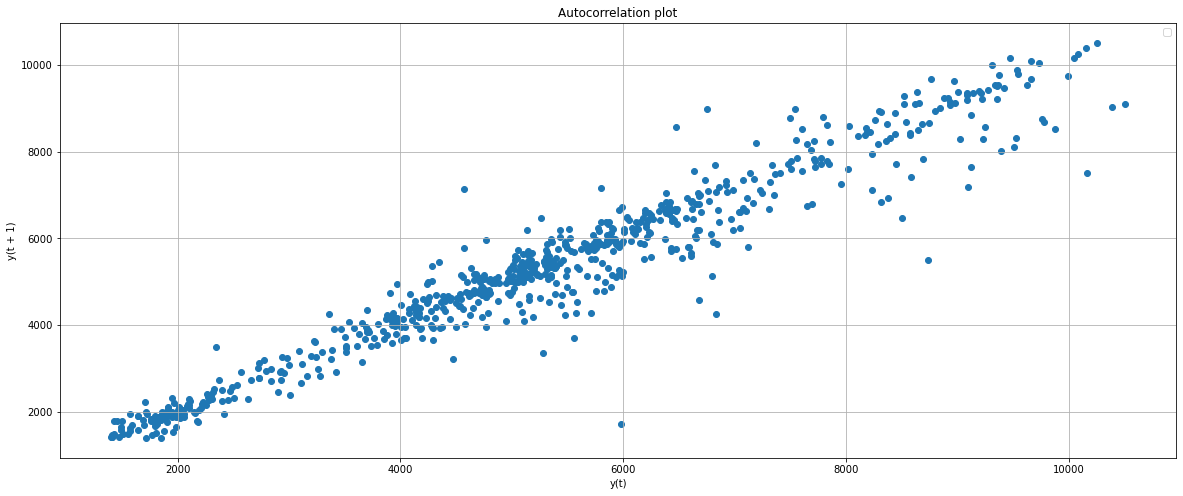

In [6]:
plt.figure(figsize=(20,8))
lag_plot(data['Num_Flights'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend();

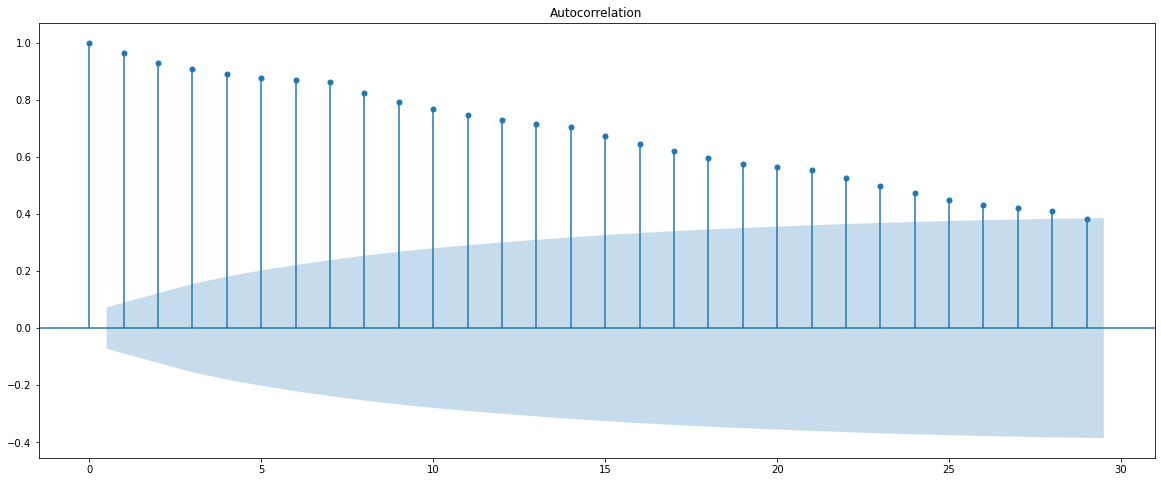

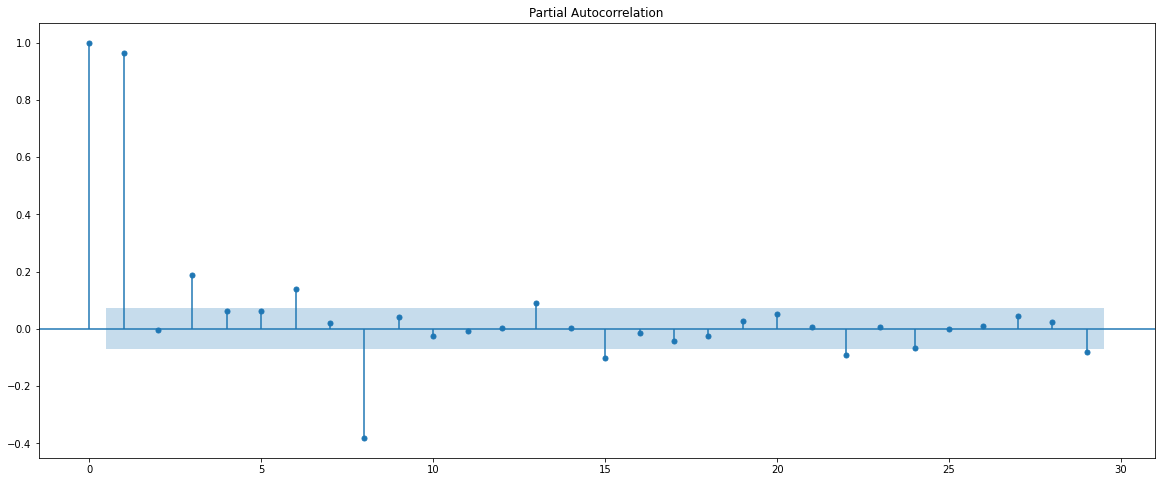

In [7]:
fig1=plot_acf(data['Num_Flights'].dropna()) 
fig2=plot_pacf(data['Num_Flights'].dropna()) 

In [8]:
values = DataFrame(data['Num_Flights'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000 -0.224504
t+1 -0.224504  1.000000


In [9]:
data.tail()

,Num_Flights,Num_Covid_Cases
Timestamp,,
2022-01-27,8174,3122335.0
2022-01-28,8376,3138982.0
2022-01-29,6924,2146044.0
2022-01-30,7230,1842602.0
2022-01-31,7112,3197167.0


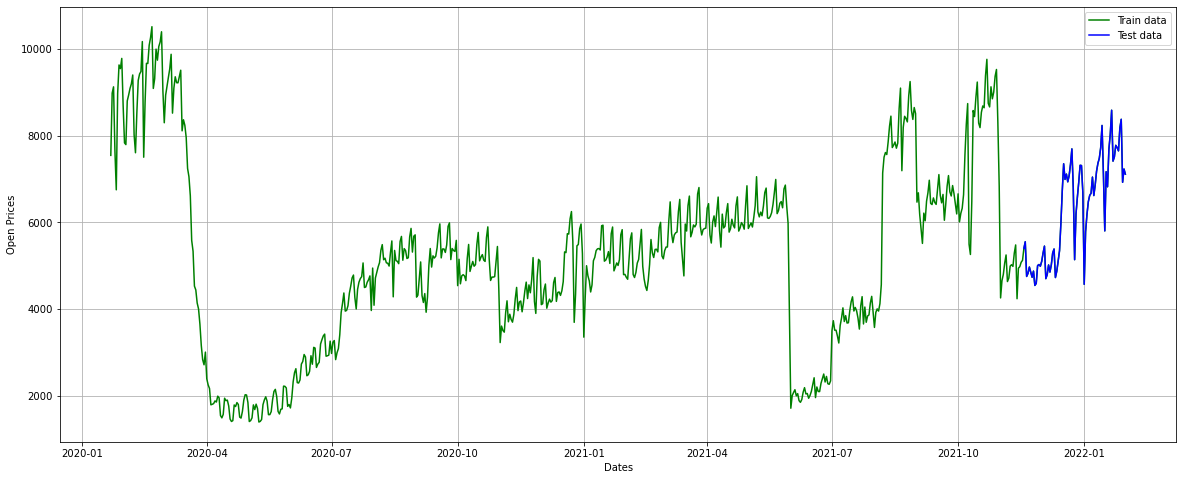

In [10]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Num_Flights'], 'green', label='Train data')
plt.plot(test_data['Num_Flights'], 'blue', label='Test data')
plt.legend()

# ARIMA model

<Figure size 1440x576 with 0 Axes>

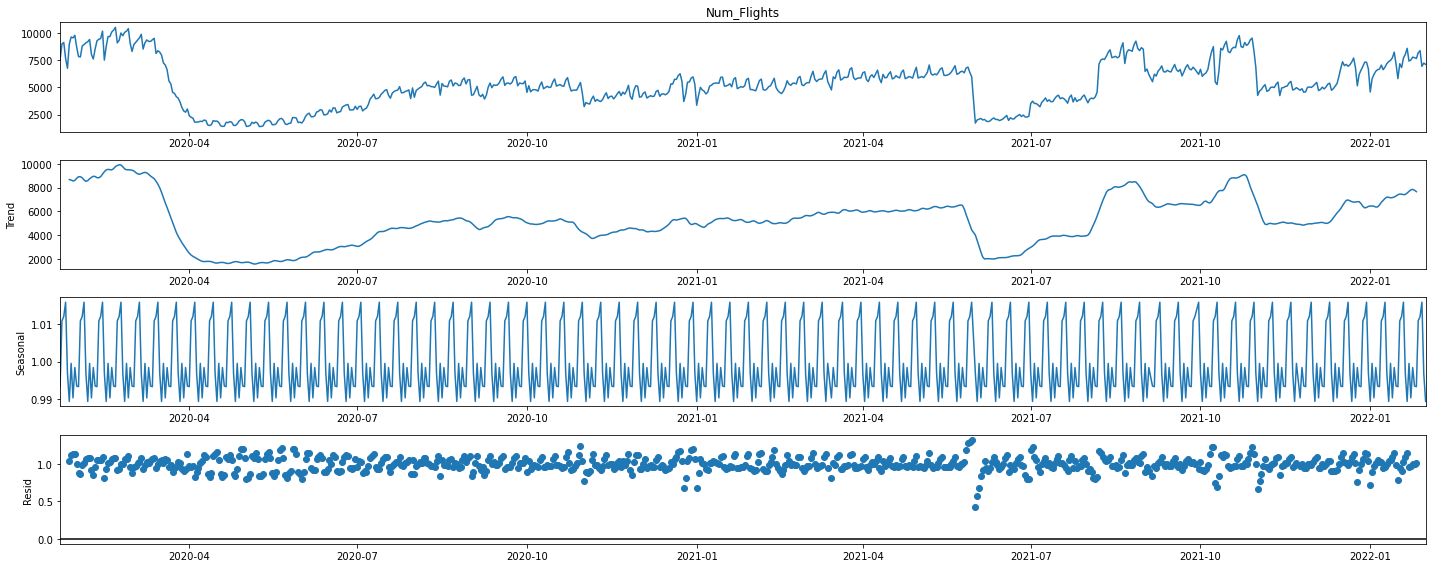

In [11]:
data_arima = data['Num_Flights']
result = seasonal_decompose(data_arima[-1000:], model='multiplicative', freq=10)
plt.figure(figsize=(20,8))
fig = result.plot()
plt.show()

In [12]:
train_arima = train_data['Num_Flights']
test_arima = test_data['Num_Flights']

In [13]:
history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

In [14]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  661
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5095.406
Method:                       css-mle   S.D. of innovations            538.988
Date:                Wed, 13 Apr 2022   AIC                          10196.812
Time:                        23:10:32   BIC                          10210.293
Sample:                             1   HQIC                         10202.037
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7057     20.552     -0.180      0.857     -43.988      36.576
ar.L1.D.y     -0.0201      0.039     -0.514      0.607      -0.097       0.056
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -49.8070           +0.0000j           49.8070            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

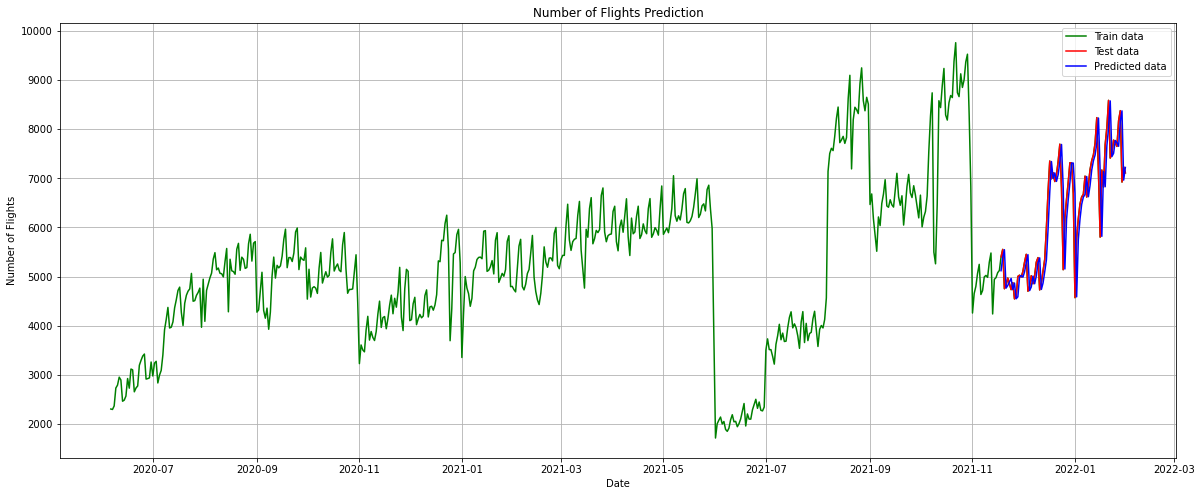

In [16]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-600:], data['Num_Flights'].tail(600), color='green', label = 'Train data')
plt.plot(test_data.index, y, color = 'red', label = 'Test data')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted data')
plt.title('Number of Flights Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

# Performance and Evaluation

In [17]:
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))
me = max_error(test_data['Num_Flights'], predictions)
print('ME: '+str(me))
score = r2_score(test_data['Num_Flights'], predictions)
print('r2 score: '+str(score))
result = adfuller(data['Num_Flights'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

MSE: 364047.23451750225
MAE: 429.23878130707396
RMSE: 603.3632691153002
ME: 2121.7392152717157
r2 score: 0.7305987043500874


{'adf': -3.370796136929915,
 'pvalue': 0.011995641459335758,
 'usedlag': 7,
 'nobs': 728,
 'criticalvalues': {'1%': -3.4393644334758475,
  '5%': -2.8655182850048306,
  '10%': -2.568888486973192},
 'icbest': 10854.481785233713}

In [18]:
predictions

[array([5121.31645539]),
 array([5392.12785767]),
 array([5547.8825658]),
 array([4767.02480253]),
 array([4820.31592498]),
 array([4964.02157048]),
 array([4736.56729434]),
 array([4869.91705714]),
 array([4550.38420717]),
 array([4589.46652429]),
 array([4991.42895225]),
 array([5024.60001703]),
 array([4987.90640814]),
 array([5096.87930822]),
 array([5286.53260231]),
 array([5447.47647033]),
 array([4715.77763083]),
 array([4790.77339772]),
 array([5010.3590394]),
 array([4855.44771231]),
 array([5014.49051072]),
 array([5285.64581489]),
 array([5381.76472701]),
 array([4740.16007492]),
 array([4870.65584095]),
 array([5099.21468759]),
 array([5340.4380658]),
 array([5972.17822032]),
 array([6719.92825019]),
 array([7340.77333594]),
 array([6996.33761082]),
 array([7110.22844364]),
 array([6937.19062243]),
 array([7074.73367883]),
 array([7334.0915864]),
 array([7688.15376661]),
 array([6815.49970474]),
 array([5155.66187342]),
 array([6171.32457816]),
 array([6569.84365272]),
 arr

In [19]:
arima_df = pd.DataFrame(predictions)
arima_df.to_csv('arima_predictions.csv')